# MNIST

This notebook is a playground for experimenting with various computer vision paradigms on the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset.

Load the necesary libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from itertools import product
import numpy as np
import pandas as pd

Download the MNIST dataset, which consists of 60000 training and 10000 test images of handwritten digits

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
assert x_train.shape == (60000, 28, 28)
assert x_test.shape == (10000, 28, 28)
assert y_train.shape == (60000,)
assert y_test.shape == (10000,)

11493376/11490434 [==============================] - 0s 0us/step


Let's take a look at some of the images

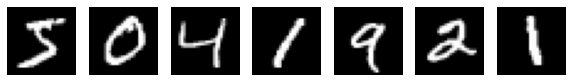

In [3]:
nr_of_images = 7

fig = plt.figure(figsize=(10,10))

for i in range(nr_of_images):
  fig.add_subplot(1, nr_of_images, i+1)
  plt.imshow(x_train[i], cmap="gray")
  plt.axis('off')


## Feature Extraction

### Filter

Let's experiment with various kernels and take a look at the feature maps.

In [4]:
def plot_kernels(kernels):
  """ Plot the given kernels in one row

  This will plot given kernels 

  Parameters:
    kernels (list of Tensorflow.Tensor): An array containing 2d tensors with shape (n, n)
                 
  Returns:
    None

  Slight adaption of https://github.com/Kaggle/learntools/blob/355a5df6a66562de62254b723da1a9389b9acc49/learntools/computer_vision/visiontools.py

  """

  nr_of_kernels = len(kernels)
  
  fig = plt.figure(figsize=(10, 10))

  for i in range(nr_of_kernels):
    kernel = np.array(kernels[i])
    fig.add_subplot(1, nr_of_kernels, i+1)
    cmap = plt.get_cmap('Blues_r')
    thresh = (kernel.max()+kernel.min())/2
    plt.imshow(kernel, cmap=cmap)
    plt.axis('off')
    rows, cols = kernel.shape
    for r, c in product(range(rows), range(cols)):
      val = kernel[r, c]
      color = cmap(0) if val > thresh else cmap(255)
      plt.text(c,r, val, 
              color=color, size=20,
              horizontalalignment='center', verticalalignment='center')


#### Constant Kernel
First define some kernels. We will start with common 3x3 kernels.

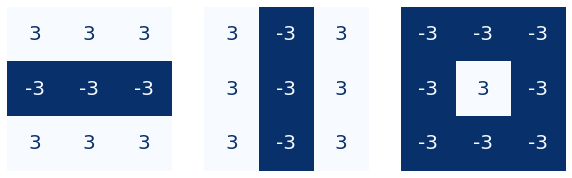

In [5]:
kernel1 = tf.constant([
      [3,3,3],
      [-3,-3,-3],
      [3,3,3]
])

kernel2 = tf.constant([
      [3,-3,3],
      [3,-3,3],
      [3,-3,3]
])

kernel3 = tf.constant([
      [-3,-3,-3],
      [-3,3,-3],
      [-3,-3,-3]
])

constant_kernels = [kernel1, kernel2, kernel3]

plot_kernels(constant_kernels)

Now let's apply the filters on random images and take a look at their activations (=feature maps).
The `tf.nn.conv2d` function, which computes a convolution, has certain requirements for its arguments:

* the `input` tensor has to have the shape `[batch_shape, in_height, in_width, in_channels]`
* the `filter` tensor has to have the shape `[filter_height, filter_width, in_channels, out_channels]`

Checkout the [docs](https://www.tensorflow.org/api_docs/python/tf/nn/conv2d) for more information.

In [6]:
def get_feature_map(image, kernel):

  image = tf.image.convert_image_dtype(image, dtype=tf.float32)
  image = tf.expand_dims(image, axis=-1)
  image = tf.expand_dims(image, axis=0)
  kernel = tf.reshape(kernel, [*kernel.shape, 1, 1])
  kernel = tf.cast(kernel, dtype=tf.float32)

  return tf.nn.conv2d(
    input=image,
    filters=kernel,
    strides=1,
    padding='SAME',
  )

def get_feature_maps(images, kernel):
  feature_maps = []

  for image in images:
    feature_map = get_feature_map(image, kernel)
    # remove dimensions of size 1, which were added before
    feature_map = tf.squeeze(feature_map)
    feature_maps.append(feature_map)

  return feature_maps


def plot_activations(images, kernel):
  feature_maps = get_feature_maps(images, kernel)

  fig = plt.figure(figsize=(10, 10))

  for i in range(nr_of_images_to_compare):
    fig.add_subplot(2, nr_of_images_to_compare, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.axis('off')
    fig.add_subplot(1, nr_of_images_to_compare, i+1)
    plt.imshow(feature_maps[i])
    plt.axis('off')

  return feature_maps

tf.Tensor(
[[ 3 -3  3]
 [ 3 -3  3]
 [ 3 -3  3]], shape=(3, 3), dtype=int32)


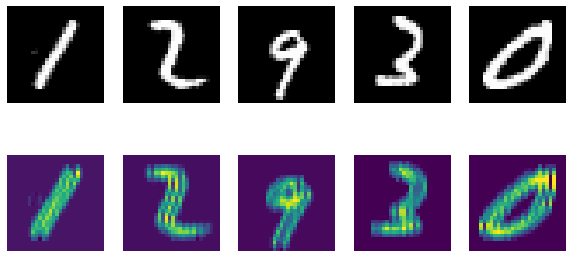

In [12]:
nr_of_images_to_compare = 5

images = [x_train[np.random.randint(0, x_train.shape[0]-1)] for i in range(nr_of_images_to_compare)]

kernel = constant_kernels[0]

kernel = tf.constant([
  [1,1],
  [-1,-1]
])

# You can change the kernel and use one of the constant kernels above

print(kernel)

feature_maps = plot_activations(images, kernel)



## Compare various models and parameters

For the softmax function in the final layer we need our labels to consist of binary class matrices.

In [13]:
num_classes = 10
y_train = keras.utils.to_categorical(y_train, num_classes)

In [14]:
x_train.shape

(60000, 28, 28)

Keras needs the channel information for the images, but as seen in the output above, our training data has the shape (nr_of_images, height, width). For Keras to work it needs (nr_of_images, height, channel). Since we have only one channel, we will expand the data by one dimension, without actually changing the data.



In [15]:
x_train = np.expand_dims(x_train, -1)
x_train.shape

(60000, 28, 28, 1)

To see how `expand_dims` work, run this code.

In [16]:
def expand_dims_explanation():
  a = np.random.randint(5, size=5)
  print("1D Array at start: {} \nshape: {}\n".format(a, a.shape))
  a = np.expand_dims(a,-1)
  print("Adding one dimension: {} \nshape: {}\n".format(a, a.shape))
  a = np.expand_dims(a,-1)
  print("Adding another dimension to make it 3D: {} \nshape: {}\n".format(a, a.shape))

expand_dims_explanation()

1D Array at start: [2 4 3 3 3] 
shape: (5,)

Adding one dimension: [[2]
 [4]
 [3]
 [3]
 [3]] 
shape: (5, 1)

Adding another dimension to make it 3D: [[[2]]

 [[4]]

 [[3]]

 [[3]]

 [[3]]] 
shape: (5, 1, 1)



Let's start with a minimum viable model **(MVP)**.

In [17]:
num_classes = 10
input_shape = (28, 28, 1)

model = keras.Sequential(
    [
      layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation="relu"),
      layers.Flatten(),
      layers.Dense(num_classes, activation="softmax"),
    ]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
flatten (Flatten)            (None, 21632)             0         
_________________________________________________________________
dense (Dense)                (None, 10)                216330    
Total params: 216,650
Trainable params: 216,650
Non-trainable params: 0
_________________________________________________________________


In [18]:
batch_size = 256
epochs = 20

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/20
211/211 [==============================] - 4s 10ms/step - loss: 2.1826 - accuracy: 0.9101 - val_loss: 0.2298 - val_accuracy: 0.9640
Epoch 2/20
211/211 [==============================] - 2s 8ms/step - loss: 0.1363 - accuracy: 0.9735 - val_loss: 0.1886 - val_accuracy: 0.9712
Epoch 3/20
211/211 [==============================] - 2s 8ms/step - loss: 0.0584 - accuracy: 0.9847 - val_loss: 0.1591 - val_accuracy: 0.9763
Epoch 4/20
211/211 [==============================] - 2s 8ms/step - loss: 0.0303 - accuracy: 0.9912 - val_loss: 0.1644 - val_accuracy: 0.9757
Epoch 5/20
211/211 [==============================] - 2s 8ms/step - loss: 0.0179 - accuracy: 0.9944 - val_loss: 0.1569 - val_accuracy: 0.9785
Epoch 6/20
211/211 [==============================] - 2s 8ms/step - loss: 0.0138 - accuracy: 0.9954 - val_loss: 0.1544 - val_accuracy: 0.9785
Epoch 7/20
211/211 [==============================] - 2s 8ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.1784 - val_accuracy: 0.9773
Epoch

Let's evaluate our model on the test set. We repeat some of the steps done for the train set.

In [19]:
x_test = np.expand_dims(x_test, -1)

In [20]:
y_test = keras.utils.to_categorical(y_test, num_classes)

In [21]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Loss: {} ".format(score[0]))
print("Accuracy: {} ".format(score[1]))

Loss: 0.26162827014923096 
Accuracy: 0.9728999733924866 


Though we have a pretty good accuracy, we see that the loss is also very high. Let's investigate the issue here.

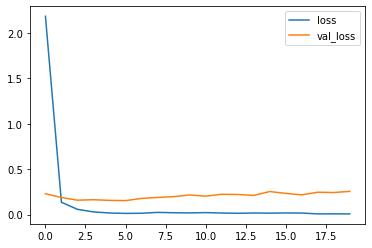

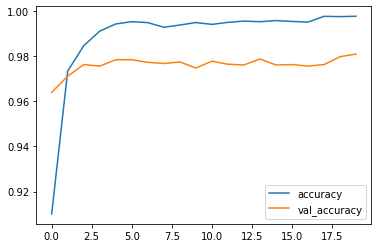

In [22]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

Taking a look at the graphs above, we can see that the gap between our validation metrics and other metrics is pretty big at the beginning and continues to grow with eath training step, indicating **overfitting**. Let's add some regularization with a **dropout** layer and see if this improves the result.

In [ ]:
model = keras.Sequential(
    [
      layers.Conv2D(32, kernel_size=(3, 3), input_shape=input_shape, activation="relu"),
      layers.Flatten(),
      layers.Dropout(0.5),
      layers.Dense(num_classes, activation="softmax"),
    ]
)

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

score = model.evaluate(x_test, y_test, verbose=0)

Epoch 1/20
211/211 [==============================] - 3s 11ms/step - loss: 2.4882 - accuracy: 0.8926 - val_loss: 0.2397 - val_accuracy: 0.9698
Epoch 2/20
211/211 [==============================] - 2s 10ms/step - loss: 0.3041 - accuracy: 0.9539 - val_loss: 0.1539 - val_accuracy: 0.9738
Epoch 3/20
211/211 [==============================] - 2s 10ms/step - loss: 0.1705 - accuracy: 0.9649 - val_loss: 0.1219 - val_accuracy: 0.9780
Epoch 4/20
211/211 [==============================] - 2s 10ms/step - loss: 0.1146 - accuracy: 0.9724 - val_loss: 0.1032 - val_accuracy: 0.9792
Epoch 5/20
211/211 [==============================] - 2s 10ms/step - loss: 0.0899 - accuracy: 0.9764 - val_loss: 0.0950 - val_accuracy: 0.9802
Epoch 6/20
211/211 [==============================] - 2s 10ms/step - loss: 0.0716 - accuracy: 0.9795 - val_loss: 0.0968 - val_accuracy: 0.9818
Epoch 7/20
211/211 [==============================] - 2s 10ms/step - loss: 0.0563 - accuracy: 0.9830 - val_loss: 0.1005 - val_accuracy: 0.9808

In [ ]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss', 'val_loss']].plot()
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot();

In [ ]:
score = model.evaluate(x_test, y_test, verbose=0)
print("Loss: {} ".format(score[0]))
print("Accuracy: {} ".format(score[1]))